In [24]:
# Import libraries
from pathlib import Path
import acoular as ac
import numpy as np

# define microphone geometry
# micgeofile = Path(ac.__file__).parent / 'xml' / 'array_64.xml'
micgeofile = Path().resolve() / "in/array_position_data/bassoon_cage_64_optimized.xml"
m = ac.MicGeom(from_file=micgeofile)

# define calculation grid
resolution = 0.01#0.02
g = ac.RectGrid3D(x_min=0.35, x_max=1.15, y_min=0.15, y_max=1.15, z_min=0.25, z_max=1.65, increment = resolution)#x_min=0, x_max=1.2, y_min=0, y_max=1.2, z_min=0, z_max=1.7, increment=resolution)

In [25]:
# Load data
name = 'in/array_audio_data/2025-01-28_15-59-01_400437.h5'

# Load whole measurement 
data = ac.MaskedTimeSamples(name = name)

print(f'number of valid channels: {data.numchannels}') 
print('length of measurement: ' + str(data.numsamples/data.sample_freq) + ' s (' + str(data.numsamples) + ' samples)')

# Load partial measurement
start = 25#83#26        # in s
stop = 35#92#36
data = ac.MaskedTimeSamples(name = name, start = start*data.sample_freq, stop = stop*data.sample_freq)
 
print('length of cropped measurement: ' + str(data.numsamples/data.sample_freq) + ' s (' + str(data.numsamples) + ' samples)')

# create WAV file from mic 1
# ac.tprocess.WriteWAV(source=data, name= 'audioFile1.wav', channels = [0]).save()

number of valid channels: 64
length of measurement: 105.92 s (5423104 samples)
length of cropped measurement: 10.0 s (512000 samples)


In [26]:
# calculate CleanSC
f = ac.PowerSpectra(source=data, window='Hanning', overlap='50%', block_size=512)#256)#128)
st = ac.SteeringVector(grid=g, mics=m, steer_type='true location')
b = ac.BeamformerCleansc(freq_data=f, steer=st)
# b = ac.fbeamform.BeamformerSODIX(freq_data=f, steer=st)

In [27]:
# calculate result
map = b.synthetic(1000, 3)
# map = ac.L_p(map)

[('2025-01-28_15-59-01_400437_cache.h5', 9)]


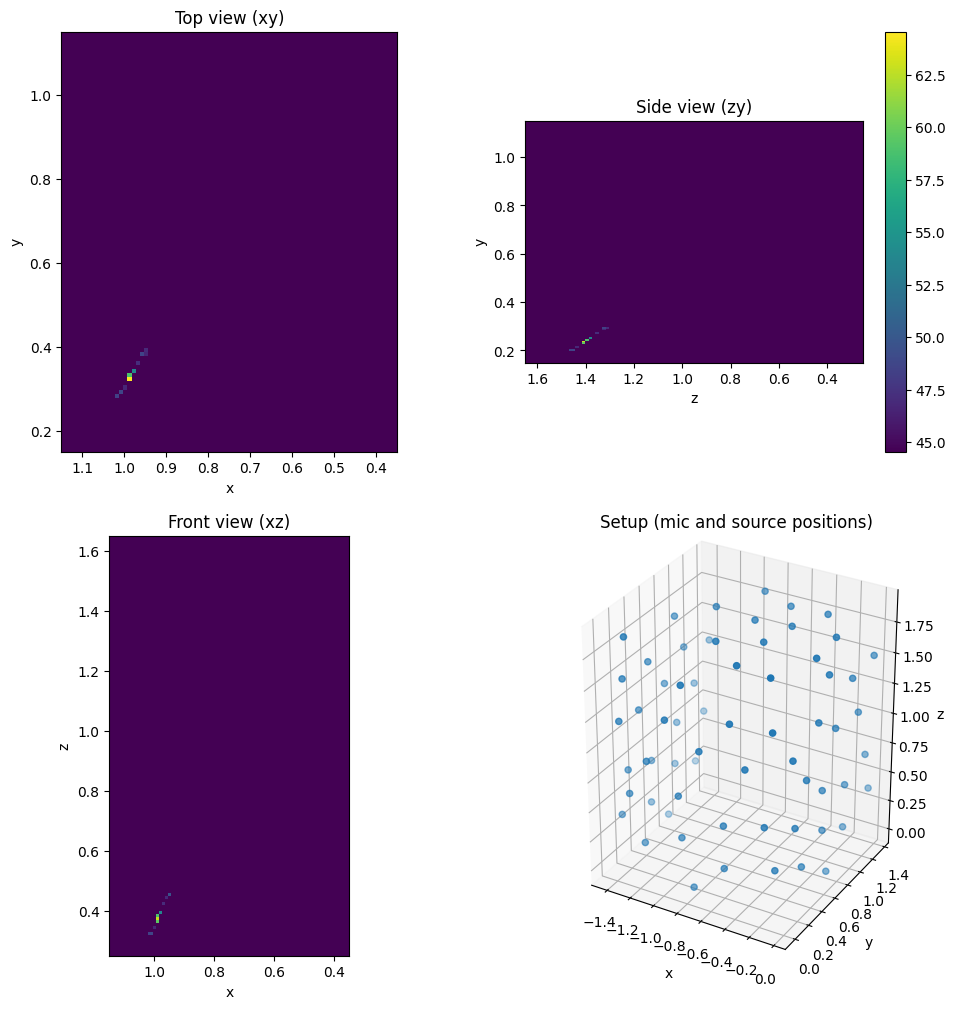

In [28]:
# plot the results
from pylab import colorbar, figure, imshow, show, subplot, title, xlabel, ylabel

fig = figure(1, (12, 12))

subplot(221)
map_z = np.sum(map, 2)
mx = ac.L_p(map_z.max())
imshow(
    ac.L_p(map_z.T),
    vmax=mx,
    vmin=mx - 20,
    origin='lower',
    interpolation='nearest',
    extent=(g.x_max, g.x_min, g.y_min, g.y_max),
    aspect = 'equal'
)
xlabel('x')
ylabel('y')
title('Top view (xy)')

subplot(223)
map_y = np.sum(map, 1)
imshow(
    ac.L_p(map_y.T),
    vmax=mx,
    vmin=mx - 20,
    origin='upper',
    interpolation='nearest',
    extent=(g.x_max, g.x_min, g.z_min, g.z_max),
    aspect = 'equal',
)
xlabel('x')
ylabel('z')
title('Front view (xz)')

subplot(222)
map_x = np.sum(map, 0)
imshow(
    ac.L_p(map_x.T),
    vmax=mx,
    vmin=mx - 20,
    origin='upper',
    interpolation='nearest',
    extent=(g.z_max, g.z_min, g.y_min, g.y_max),
    aspect = 'equal'
)
xlabel('z')
ylabel('y')
title('Side view (zy)')

colorbar()

ax0 = fig.add_subplot((224), projection='3d')
ax0.scatter(-m.mpos[0], m.mpos[1], m.mpos[2])
# source_locs = np.array([p1.loc, p2.loc, p3.loc]).T
# ax0.scatter(source_locs[0], source_locs[1], -source_locs[2])
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel('z')
ax0.set_title('Setup (mic and source positions)')
ax0.set_aspect('equal')
show()

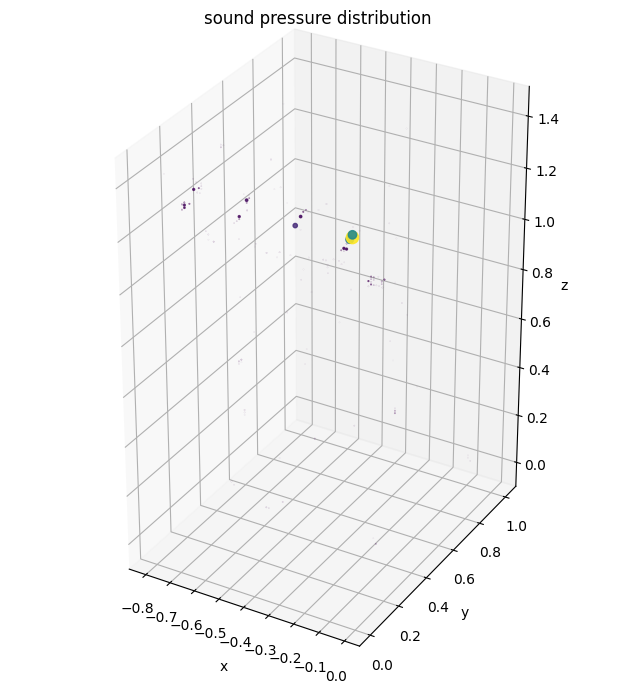

In [29]:
import matplotlib.pyplot as plt

dotsize = 5


fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[0]*resolution,map.shape[0]),np.linspace(0,map.shape[1]*resolution,map.shape[1]), np.linspace(0,map.shape[2]*resolution,map.shape[2]))
ax.scatter(-x_m, y_m, z_m, c = map, s = map*10**dotsize)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('sound pressure distribution')
ax.set_aspect('equal')
show()